In [8]:
!git clone https://github.com/arcriles/TugasAkhirAI

Cloning into 'TugasAkhirAI'...
remote: Enumerating objects: 4388, done.
remote: Counting objects: 100% (4388/4388), done.
remote: Compressing objects: 100% (4356/4356), done.
remote: Total 4388 (delta 13), reused 4387 (delta 12), pack-reused 0
Receiving objects: 100% (4388/4388), 349.35 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (4421/4421), done.
time: 22.2 s (started: 2021-11-14 20:15:16 +00:00)


In [10]:
%cd face-mask-detection/

!ls

[Errno 2] No such file or directory: 'face-mask-detection/'
/content/face-mask-detection
'aplikasi android'
 Aplikasi-Android.gif
'berkas tugas akhir'
 dataset
 deploy.prototxt
 example_img
 face-detector.zip
 Face_Mask_Detection_MobileNetV2_with_MTCNN.ipynb
 Face_Mask_Detection_MobileNetV2_with_ResNet10.ipynb
 Face_Mask_Detection_VGG16Net_with_MTCNN.ipynb
 Face_Mask_Detection_VGG16Net_with_ResNet10.ipynb
 Full_Face_Mask_Detection_MobileNetV2.ipynb
 Full_Face_Mask_Detection_VGG16Net.ipynb
 logo-md1png.png
 mask_model.tflite
 pengujian
 README.md
 res10_300x300_ssd_iter_140000.caffemodel
 TugasAkhirAI
time: 176 ms (started: 2021-11-14 20:15:43 +00:00)


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [11]:
!unzip face-detector.zip

Archive:  face-detector.zip
replace deploy.prototxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  
time: 7.1 s (started: 2021-11-14 20:15:46 +00:00)


## Mengimport *Library*

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
 
!pip install ipython-autotime
 
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.31 s (started: 2021-11-14 20:15:57 +00:00)


In [14]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
 
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
for imagePath in imagePaths:
 
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    data.append(image)
    labels.append(label)
 
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("It Works!")

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


It Works!
time: 17.1 s (started: 2021-11-14 20:17:03 +00:00)


In [16]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 617 ms (started: 2021-11-14 20:19:42 +00:00)


## Membuat Model Jaringan CNN

In [17]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

time: 1.35 s (started: 2021-11-14 20:20:17 +00:00)


### *Feature Extraction*

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama.

In [18]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Tahap Pembuatan Model

In [19]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Melakukan Pelatihan Model

In [20]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/30
95/95 [==============================] - 73s 431ms/step - loss: 0.4342 - accuracy: 0.8220 - val_loss: 0.1663 - val_accuracy: 0.9791
Epoch 2/30
95/95 [==============================] - 39s 415ms/step - loss: 0.1475 - accuracy: 0.9631 - val_loss: 0.0874 - val_accuracy: 0.9817
Epoch 3/30
95/95 [==============================] - 39s 409ms/step - loss: 0.0948 - accuracy: 0.9756 - val_loss: 0.0647 - val_accuracy: 0.9831
Epoch 4/30
95/95 [==============================] - 39s 407ms/step - loss: 0.0772 - accuracy: 0.9812 - val_loss: 0.0554 - val_accuracy: 0.9857
Epoch 5/30
95/95 [==============================] - 39s 408ms/step - loss: 0.0612 - accuracy: 0.9858 - val_loss: 0.0561 - val_accuracy: 0.9844
Epoch 6/30
95/95 [==============================] - 38s 402ms/step - loss: 0.0596 - accuracy: 0.9806 - val_loss: 0.0481 - val_accuracy: 0.9870
Epoch 7/30
95/95 [==============================] - 38s 400ms/step - loss: 0.0580 - accuracy: 0.9822 - val_loss: 0.0545

### Menampilkan Kurva Model Hasil Pelatihan

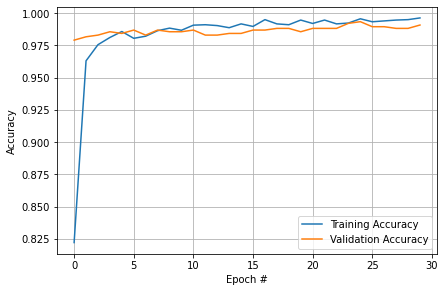

time: 276 ms (started: 2021-11-14 20:46:13 +00:00)


In [22]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

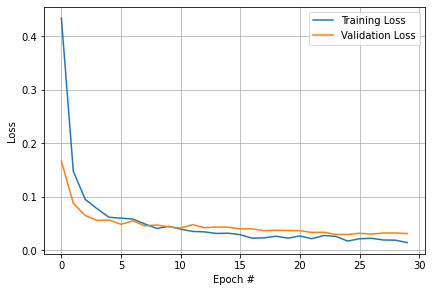

time: 208 ms (started: 2021-11-14 20:46:20 +00:00)


In [23]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid(zorder = 0)
plt.show()

**yang belum dilakukan:**
1. *evaluasi training*
2. *mengekspor training untuk aplikasi mobile*
3. *test model dengan cnn (mtcnn, untuk mempermudah pekerjaan dibandingkan membuat module python dari awal.)*

3:54:20 AM, 15 November 2021 *(by: Arcriles Thungriallu)*